In [279]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [280]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target

In [281]:
X_no_target = X.copy()

In [282]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_no_target)

In [283]:
#Ищем наилучшие параметры для AgglomerativeClustering
best_completeness = 0
best_params_agg = {}
for linkage in ['ward', 'complete', 'average', 'single']:
    agg = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    agg_labels = agg.fit_predict(X_scaled)
    completeness = completeness_score(y, agg_labels)
    if completeness > best_completeness:
        best_completeness = completeness
        best_params_agg = {'linkage': linkage}

print("Completeness для AgglomerativeClustering:", best_completeness)
print("Лучшие параметры для AgglomerativeClustering:", best_params_agg)

Completeness для AgglomerativeClustering: 0.7825408201875712
Лучшие параметры для AgglomerativeClustering: {'linkage': 'ward'}


In [284]:
#Ищем наилучшие параметры для DBSCAN
best_completeness_dbscan = 0
best_params_dbscan = {}
for eps in np.arange(0.1, 3.0, 0.1):
    for min_samples in range(2, 30):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        if len(set(dbscan_labels)) > 1:  # Избегаем результатов с только шумом
            completeness = completeness_score(y, dbscan_labels)
            if completeness > best_completeness_dbscan:
                best_completeness_dbscan = completeness
                best_params_dbscan = {'eps': eps, 'min_samples': min_samples}

print("Completeness для DBSCAN:", best_completeness_dbscan)
print("Лучшие параметры для DBSCAN:", best_params_dbscan)


Completeness для DBSCAN: 0.7333395364598793
Лучшие параметры для DBSCAN: {'eps': 2.6, 'min_samples': 25}


In [285]:
np.random.seed(1234)
num_clusters = 3

clusterizators = [
    ('KMeans++', KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=10, random_state=42)),
    ('Ward Linkage', AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')),
    ('DBSCAN (2.6)', DBSCAN(eps=2.6, min_samples=25))
]

In [286]:
metrics_name = ['homogeneity_score', 'completeness_score', 'v_measure_score', 'time, ms']
clustering_metrics = [homogeneity_score, completeness_score, v_measure_score]

In [287]:
res_df = pd.DataFrame(columns=['Metric'])
res_df['Metric'] = metrics_name

In [288]:
for name, cmodel in clusterizators:
    t0 = time.time()
    if hasattr(cmodel, "fit_predict"):
        labels = cmodel.fit_predict(X_scaled)
    else:
        cmodel.fit(X_scaled)
        labels = cmodel.labels_.astype(int)
    t1 = time.time()

  # Расчет метрик
    scores = []
    for metric_fn in clustering_metrics:
        try:
            score = metric_fn(y, labels)
            scores.append(score)
        except:
            scores.append(np.nan)
    scores.append((t1 - t0) * 1000)
    res_df[name] = scores

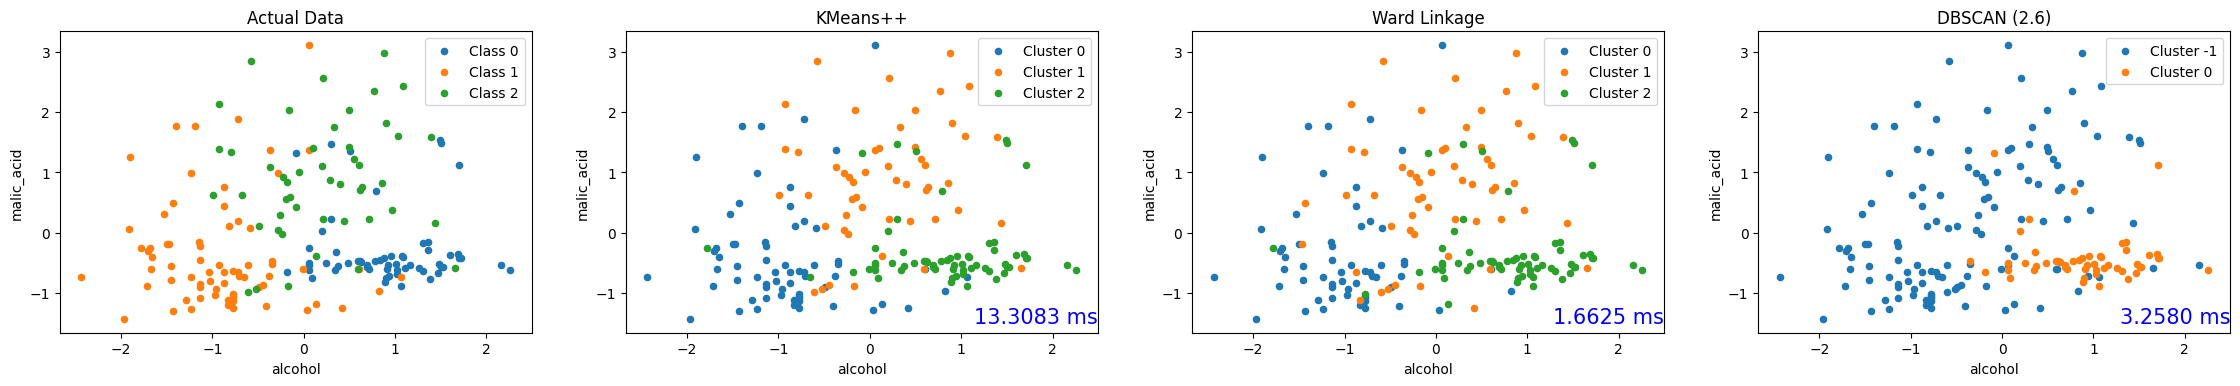

In [289]:
fig = plt.figure(figsize=(28, 18))
size = 20
x_label, y_label = wine.feature_names[0], wine.feature_names[1]
ax = plt.subplot(4, 4, 1)
plt.title('Actual Data')

dfr = pd.DataFrame(X_scaled, columns=wine.feature_names)
dfr['class'] = y

for c, rows in dfr.groupby('class'):
    plt.scatter(rows.iloc[:, 0], rows.iloc[:, 1], s=size, label=f'Class {c}')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()

i = 2
for name, cmodel in clusterizators:
    ax = plt.subplot(4, 4, i)
    t0 = time.time()

    if hasattr(cmodel, "fit_predict"):
        labels = cmodel.fit_predict(X_scaled)
    else:
        cmodel.fit(X_scaled)
        labels = cmodel.labels_.astype(int)

    t1 = time.time()

    scores = []
    for metric_fn in clustering_metrics:
        try:
            score = metric_fn(y, labels)
            scores.append(score)
        except:
            scores.append(np.nan)
    scores.append((t1 - t0) * 1000)
    res_df[name] = scores

    plt.title(name)
    dfr['cluster'] = labels
    for cluster_label, rows in dfr.groupby('cluster'):
        plt.scatter(rows.iloc[:, 0], rows.iloc[:, 1], s=size, label=f'Cluster {cluster_label}')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()

    ax.text(
        2.5, -1.5,
        f"{(t1 - t0) * 1000:.4f} ms",
        size=15, horizontalalignment='right', color='b'
    )
    i += 1
plt.show()

In [290]:
res_df

,Metric,KMeans++,Ward Linkage,DBSCAN (2.6)
0,homogeneity_score,0.878843,0.790429,0.407882
1,completeness_score,0.872964,0.782541,0.733340
2,v_measure_score,0.875894,0.786465,0.524203
3,"time, ms",13.308287,1.662493,3.257990


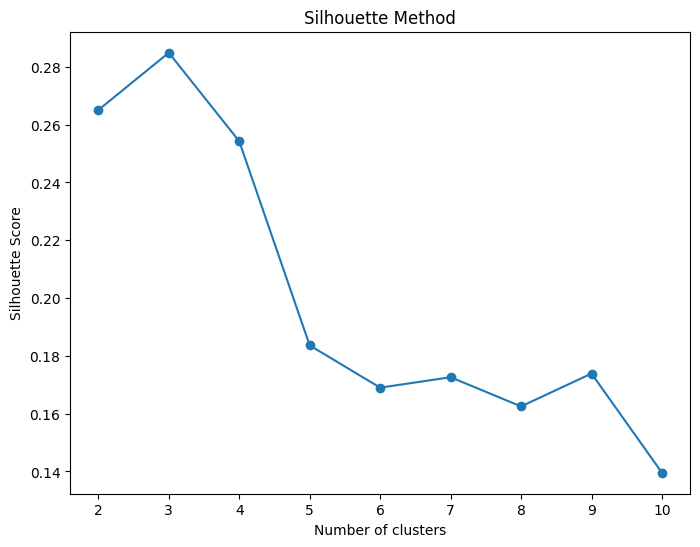

In [291]:
from sklearn.metrics import silhouette_score

#Используем коэффициент силуэта, чтобы узнать оптимальное количество кластеров для kmeans++

silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

In [292]:
#Наиболее хорошие значения метрик показал kmeans++, самые минимальные значения метрики у DBSCAN.
#Можно сделать вывод, что для данного датасета kmeans++ подходит лучше всего. Однако, Ward Linkage дает тоже неплохие результаты
#С помощью коэффициента силуэта на kmeans++ было выявлено оптимальное число кластеров - 3, которое изначально и использовалось.